# Finding Grids.
As a starter we boil down the problem to the case where neighborhoods are
made out of street grids. Now we want to find such grids in cities.
- connected
- consisting of two fixed street directions, not necessarily at $90\degree$
to each other


In [1]:
import osmnx as ox
import networkx as nx
import numpy as np

We start by importing a street network, make it **unidirected** and add the
streets orientations aka bearings.
Feel free to change the input graph by modifying the location string (find
fitting one with [Nominatim](https://nominatim.openstreetmap.org/ui/search.html)).
We use the example of Brooklyn, NY, because the streets consists out of
grids, which have a variety of orientations, as well as some parts which do
not belong to a grid.

## Find straight sections

In [2]:
G = ox.graph_from_place("Brooklyn")
G = ox.get_undirected(G)
G = ox.add_edge_bearings(G)

In [ ]:
ox.plot_graph_folium(G)

Note: Working with bearings from OSMnx does return angles in the
$[0\degree, 360\degree)$, but is not able to distinguish between angles modulo
$180\degree$. The `bearing` attribute is fixed to an edge, as it is
undirected. Example: Graph data returns `(u, v, 351.2)` and `
(v, u, 351.2)`.

In [71]:
def subgraph_of_degree(graph: nx.Graph, n: int):
    node_degrees = nx.degree(graph)
    return nx.subgraph(graph, [node for node in graph.nodes() if
                               node_degrees[node] == n])


def point_from_node_id(graph: nx.Graph, nodeID: int) -> tuple:
    """
    Extracts (lat, lng) point from node attributes of graph.

    :param graph: Graph with nodes
    :param nodeID: Node ID to find in graph
    :return: (lat, lng) of node
    """
    return tuple(graph.nodes()[nodeID][key] for key in ('y', 'x'))


def smallest_angle_differences(G: nx.Graph, nodeID: int):
    n = 5
    a = np.zeros((n, n), dtype=float)
    for i in range(0, n):
        for j in range(0, i):
            a[i][j] = True


def find_straights(graph: nx.Graph, angle_tolerance: float = 2.0) -> list:
    """
    Find straight sections in graph.

    :param graph: Graph to find straight lines on. Must have x and y
    coordinate like from OSMnx and edge bearings.
    :param angle_tolerance: Tolerance angle at nodes for two edges to be
    considered a straight line
    :return: List of straight lines, represented as lists of node ids.
    """
    graph_4 = subgraph_of_degree(graph, 4)
    # bearings = graph.edges.data('bearing')
    lines = list()

    seen_nodes = list()
    for u in graph_4.nodes:
        line = list()
        if u in seen_nodes: continue
        seen_nodes.append(u)
        for u, v, bearing in G.edges(nbunch=u, data='bearing'):
            if v in seen_nodes: continue  #?
            if
    return lines


find_straights(G)

In [93]:
direct_edge_bearings = list(G.edges(nbunch=2317301788, data='bearing'))
n = len(direct_edge_bearings)
a = np.full((n, n), fill_value=np.inf, dtype=float)

# Calculate angle distance for lower triangle of pairwise matrix,
# cause function is symmetric.
for i in range(0, n):
    for j in range(0, i):
        a[i][j] = abs(((direct_edge_bearings[i][2] - direct_edge_bearings[j][2])
                       + 90) % 180 - 90)
# Find minima - finds not just straights, but also edges splitting to parallel
k = int(n / 2)  # how many pairs to return - should be floor(number of edges)
# - this might miss straight lines if there are nearly parallel edges. This
# should not be relevant as this is assumed to be rare for a neighborhood and
# here we just seed the straight lines
a_sort_to_k = np.argpartition(a.ravel(), k)
a_min_idx = np.array(np.unravel_index(a_sort_to_k, a.shape))[:,
            range(k)].transpose().tolist()
a, a_min_idx, [a[i, j] for i, j in a_min_idx], [(direct_edge_bearings[i][1],
                                                 direct_edge_bearings[j][1])
                                                for i, j in a_min_idx]

(array([[ inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf],
        [40.4,  inf,  inf,  inf,  inf,  inf,  inf,  inf],
        [37.3,  3.1,  inf,  inf,  inf,  inf,  inf,  inf],
        [50.8, 10.4, 13.5,  inf,  inf,  inf,  inf,  inf],
        [48.3,  7.9, 11. ,  2.5,  inf,  inf,  inf,  inf],
        [25.9, 66.3, 63.2, 76.7, 74.2,  inf,  inf,  inf],
        [43.1, 83.5, 80.4, 86.1, 88.6, 17.2,  inf,  inf],
        [44.2, 84.6, 81.5, 85. , 87.5, 18.3,  1.1,  inf]]),
 [[7, 6], [4, 3], [2, 1], [4, 1]],
 [1.1000000000000227, 2.5, 3.1000000000000227, 7.900000000000006],
 [(5618034399, 448100066),
  (1955847954, 2317301761),
  (1955847991, 448096469),
  (1955847954, 448096469)])

In [6]:
direct_edge_bearings

[(2317301788, 42461914, 351.2),
 (2317301788, 448096469, 31.6),
 (2317301788, 1955847991, 208.5),
 (2317301788, 2317301761, 42.0),
 (2317301788, 1955847954, 39.5),
 (2317301788, 5618034410, 325.3),
 (2317301788, 448100066, 128.1),
 (2317301788, 5618034399, 307.0)]

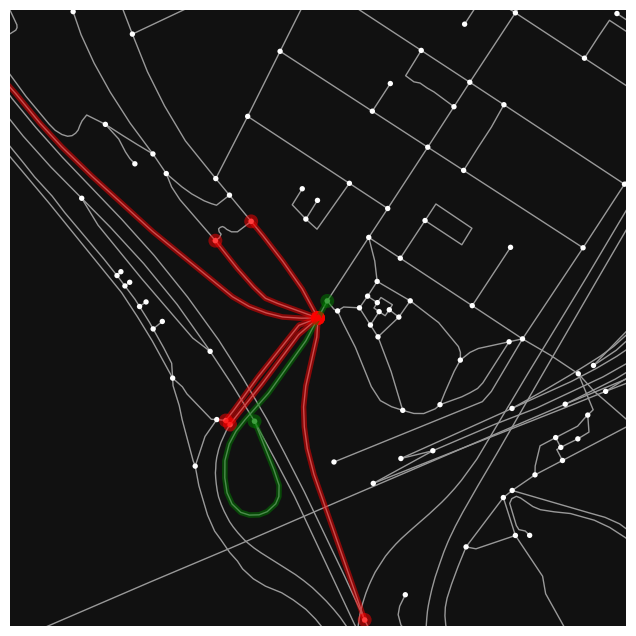

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [97]:
arms = [list(r[:2]) for r in direct_edge_bearings]
arm_colors = ['red' if arm[1] not in [1955847991, 448096469] else 'green'
              for
              arm in arms]
ox.plot_graph_routes(G, arms, route_colors=arm_colors,
                     bbox=ox.utils_geo.bbox_from_point(point_from_node_id(G,
                                                                          2317301788),
                                                       dist=300))

## Fourier transformation

Wishlist:
- 2d Fourier transform
- Examine periodicity
- Recognize pattern for partitions
- Filter
- Inverse transform into partitions

In [2]:
from scipy.fft import fft2, ifft2
from math import ceil
from matplotlib import pyplot as plt

Use Manhattan, NY as first sample, as it is mostly composed out of one grid.
Construct 2d binary matrix where each bin corresponds to a bounding box,
which are contiguous
$$c_{ij} = \begin{cases} 1 &\quad\exists\text{node in }c_{ij}\\ 0 &\quad
\text{otherwise}\end{cases}$$

In [229]:
G = ox.graph_from_place("Manhattan")

In [192]:
G = ox.graph_from_place("Harlem, Manhattan", network_type='drive')

In [132]:
G = ox.graph_from_bbox(40.69534, 40.66393, -73.84473, -73.80452)

In [ ]:
ox.plot_graph_folium(G)

In [231]:
coordinates = np.reshape([(n[0], n[1]['y'], n[1]['x']) for n in G.nodes.data()],
                         (-1, 3))
bbox_coord = (coordinates[:, 1].max(), coordinates[:, 1].min(),
              coordinates[:, 2].max(), coordinates[:, 2].min())
delta_lat_long = (ox.distance.great_circle_vec(bbox_coord[0],
                                               sum(bbox_coord[2:]) / 2,
                                               bbox_coord[1],
                                               sum(bbox_coord[2:]) / 2),
                  ox.distance.great_circle_vec(sum(bbox_coord[:2]) / 2,
                                               bbox_coord[2],
                                               sum(bbox_coord[:2]) / 2,
                                               bbox_coord[3])
                  )  # in meter
bin_width = 8.0  # in meter
shape = tuple(ceil(d / bin_width) for d in delta_lat_long)
# # Enlarge bbox_coord by a bin width
# bin_width_lat_long = ((bbox_coord[0] - bbox_coord[1]) / (shape[0]),
#                       (bbox_coord[2] - bbox_coord[3]) / (shape[1]))
# bbox_coord = (bbox_coord[0] + bin_width_lat_long[0] / 2,
#               bbox_coord[1] - bin_width_lat_long[0] / 2,
#               bbox_coord[2] + bin_width_lat_long[1] / 2,
#               bbox_coord[3] - bin_width_lat_long[1] / 2)
shape

(2465, 1180)

In [232]:
import operator
from numpy.lib.histograms import _get_outer_edges

# Calculate histogram
samples = coordinates[:, 1:]
N, D = samples.shape
nbin = np.empty(D, int)
edges = D * [None]
dedges = D * [None]
rang = (None,) * D

# Create edge arrays
for i in range(D):
    smin, smax = _get_outer_edges(samples[:, i], rang[i])
    n = operator.index(shape[i])

    edges[i] = np.linspace(smin, smax, n + 1)

    nbin[i] = len(edges[i]) + 1  # includes an outlier on each end
    dedges[i] = np.diff(edges[i])

# Compute the bin number each sample falls into.
Ncount = tuple(
    # avoid np.digitize to work around gh-11022
    np.searchsorted(edges[i], samples[:, i], side='right')
    for i in range(D)
)

# Using digitize, values that fall on an edge are put in the right bin.
# For the rightmost bin, we want values equal to the right edge to be
# counted in the last bin, and not as an outlier.
for i in range(D):
    # Find which points are on the rightmost edge.
    on_edge = (samples[:, i] == edges[i][-1])
    # Shift these points one bin to the left.
    Ncount[i][on_edge] -= 1

# Compute the sample indices in the flattened histogram matrix.
# This raises an error if the array is too large.
xy = np.ravel_multi_index(Ncount, nbin)

# Compute the number of repetitions in xy and assign it to the
# flattened histmat.
c = np.bincount(xy, minlength=nbin.prod())

# Shape into a proper matrix
c = c.reshape(nbin)

# This preserves the (bad) behavior observed in gh-7845, for now.
c = c.astype(float, casting='safe')

# Remove outliers (indices 0 and -1 for each dimension).
core = D * (slice(1, -1),)
c = c[core]

if (c.shape != nbin - 2).any():
    raise RuntimeError(
        "Internal Shape Error")

# c, edges = np.histogramdd(coordinates, bins=shape)
# c = c.transpose()
c = (c > 0) * 1
c.max()

1

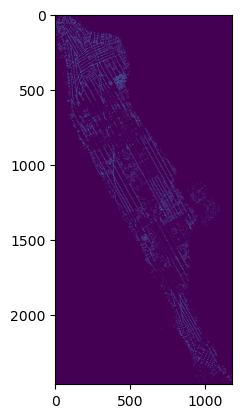

In [233]:
plt.imshow(c, interpolation=None)
# plt.savefig('test.pdf')

In [234]:
c_fft = fft2(c)

In [235]:
c_fft_filtered = c_fft
c_fft_filtered = (abs(c_fft_filtered) > 4 * abs(
    c_fft_filtered).mean()) * c_fft_filtered

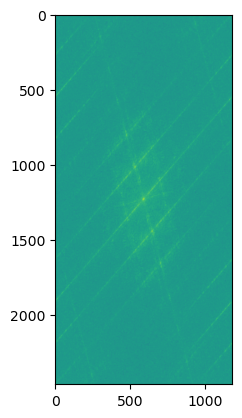

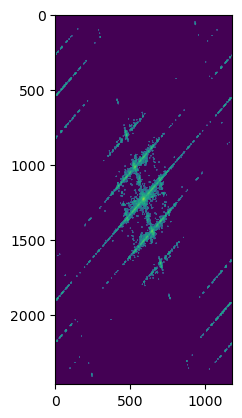

In [236]:
from numpy.fft import fftshift

plt.imshow(abs(fftshift(c_fft)), interpolation=None, norm='symlog')
plt.show()
plt.imshow(abs(fftshift(c_fft_filtered)), interpolation=None, norm='symlog')

In [237]:
c_ifft = ifft2(c_fft)
c_ifft_filtered = ifft2(c_fft_filtered)

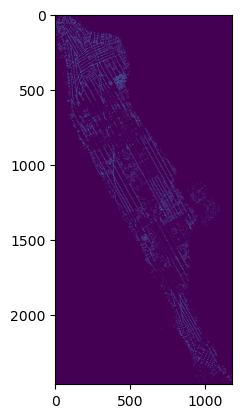

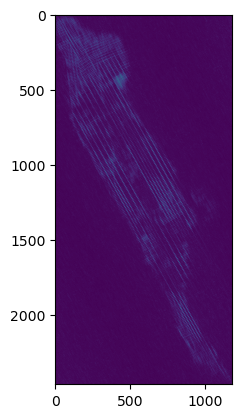

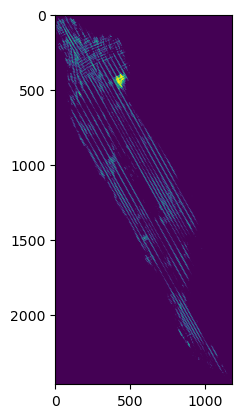

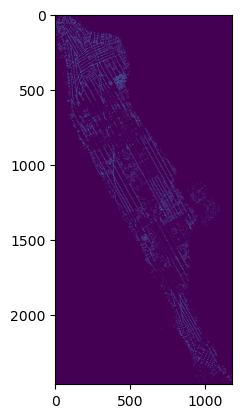

In [238]:
plt.imshow(c_ifft.real, interpolation=None)
plt.show()
plt.imshow(abs(c_ifft_filtered), interpolation=None)
plt.show()
plt.imshow((abs(c_ifft_filtered) > 5 * abs(c_ifft_filtered).mean()),
           interpolation=None)
plt.show()
plt.imshow(c, interpolation=None)

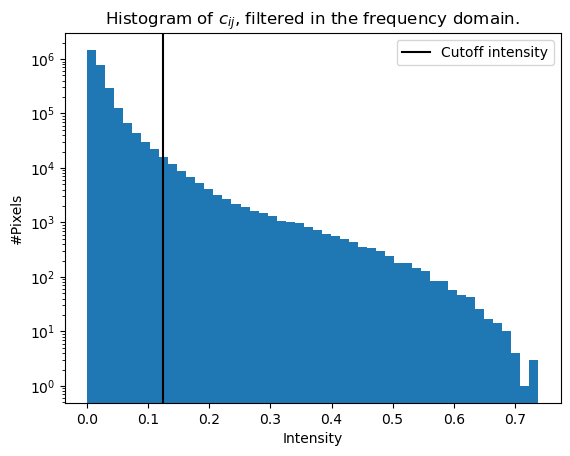

In [239]:
n, _, _ = plt.hist(abs(c_ifft_filtered).flatten(), bins=50, log=True)
plt.axvline(5 * abs(c_ifft_filtered).mean(), color='black',
            label="Cutoff intensity")
plt.title('Histogram of $c_{ij}$, filtered in the frequency domain.')
plt.xlabel("Intensity")
plt.ylabel("#Pixels")
plt.legend()

In [240]:
from scipy.ndimage import maximum_filter

filtered_indices = (
    maximum_filter(abs(c_ifft_filtered) > 5 * abs(c_ifft_filtered).mean(),
                   size=2)).nonzero()
filtered_indices = [[filtered_indices[0][i], filtered_indices[1][i]]
                    for i in range(len(filtered_indices[0]))]
filtered_indices

[[5, 64],
 [5, 65],
 [5, 66],
 [6, 64],
 [6, 65],
 [6, 66],
 [13, 70],
 [13, 71],
 [14, 69],
 [14, 70],
 [14, 71],
 [14, 72],
 [15, 69],
 [15, 70],
 [15, 71],
 [15, 72],
 [16, 69],
 [16, 70],
 [16, 71],
 [16, 72],
 [22, 74],
 [22, 75],
 [22, 76],
 [23, 74],
 [23, 75],
 [23, 76],
 [23, 77],
 [24, 19],
 [24, 20],
 [24, 67],
 [24, 68],
 [24, 74],
 [24, 75],
 [24, 76],
 [24, 77],
 [25, 19],
 [25, 20],
 [25, 66],
 [25, 67],
 [25, 68],
 [25, 74],
 [25, 75],
 [25, 76],
 [25, 77],
 [26, 66],
 [26, 67],
 [27, 58],
 [27, 59],
 [27, 66],
 [27, 67],
 [27, 102],
 [27, 103],
 [27, 104],
 [27, 105],
 [27, 106],
 [27, 107],
 [27, 108],
 [28, 58],
 [28, 59],
 [28, 66],
 [28, 67],
 [28, 73],
 [28, 74],
 [28, 101],
 [28, 102],
 [28, 103],
 [28, 104],
 [28, 105],
 [28, 106],
 [28, 107],
 [28, 108],
 [29, 73],
 [29, 74],
 [29, 75],
 [29, 88],
 [29, 89],
 [29, 100],
 [29, 101],
 [29, 102],
 [29, 103],
 [29, 104],
 [29, 105],
 [29, 106],
 [29, 107],
 [29, 108],
 [30, 72],
 [30, 73],
 [30, 74],
 [30, 75],
 [3

In [241]:
filtered_node_ids = list()
for i, bins in enumerate(np.transpose(Ncount)):
    if list(bins) in filtered_indices:
        # print(i, bins, coordinates[i, 0])
        filtered_node_ids.append(int(coordinates[i, 0]))
G.add_nodes_from(G.nodes, node_color=0)
G.add_nodes_from(filtered_node_ids, node_color=1)

In [242]:
attr = {}
for u, v, key in G.edges(keys=True):
    if u in filtered_node_ids:
        if v in filtered_node_ids:
            attr[(u, v, key)] = 1.0
        else:
            attr[(u, v, key)] = 0.5
    elif v in filtered_node_ids:
        attr[(u, v, key)] = 0.5
    else:
        attr[(u, v, key)] = 0.0
nx.set_edge_attributes(G, attr, 'edge_color')

In [244]:
G.nodes('node_color').__len__(), G.edges.data('edge_color').__len__()

(38114, 112963)

In [248]:
G_filtered = G.subgraph(filtered_node_ids)

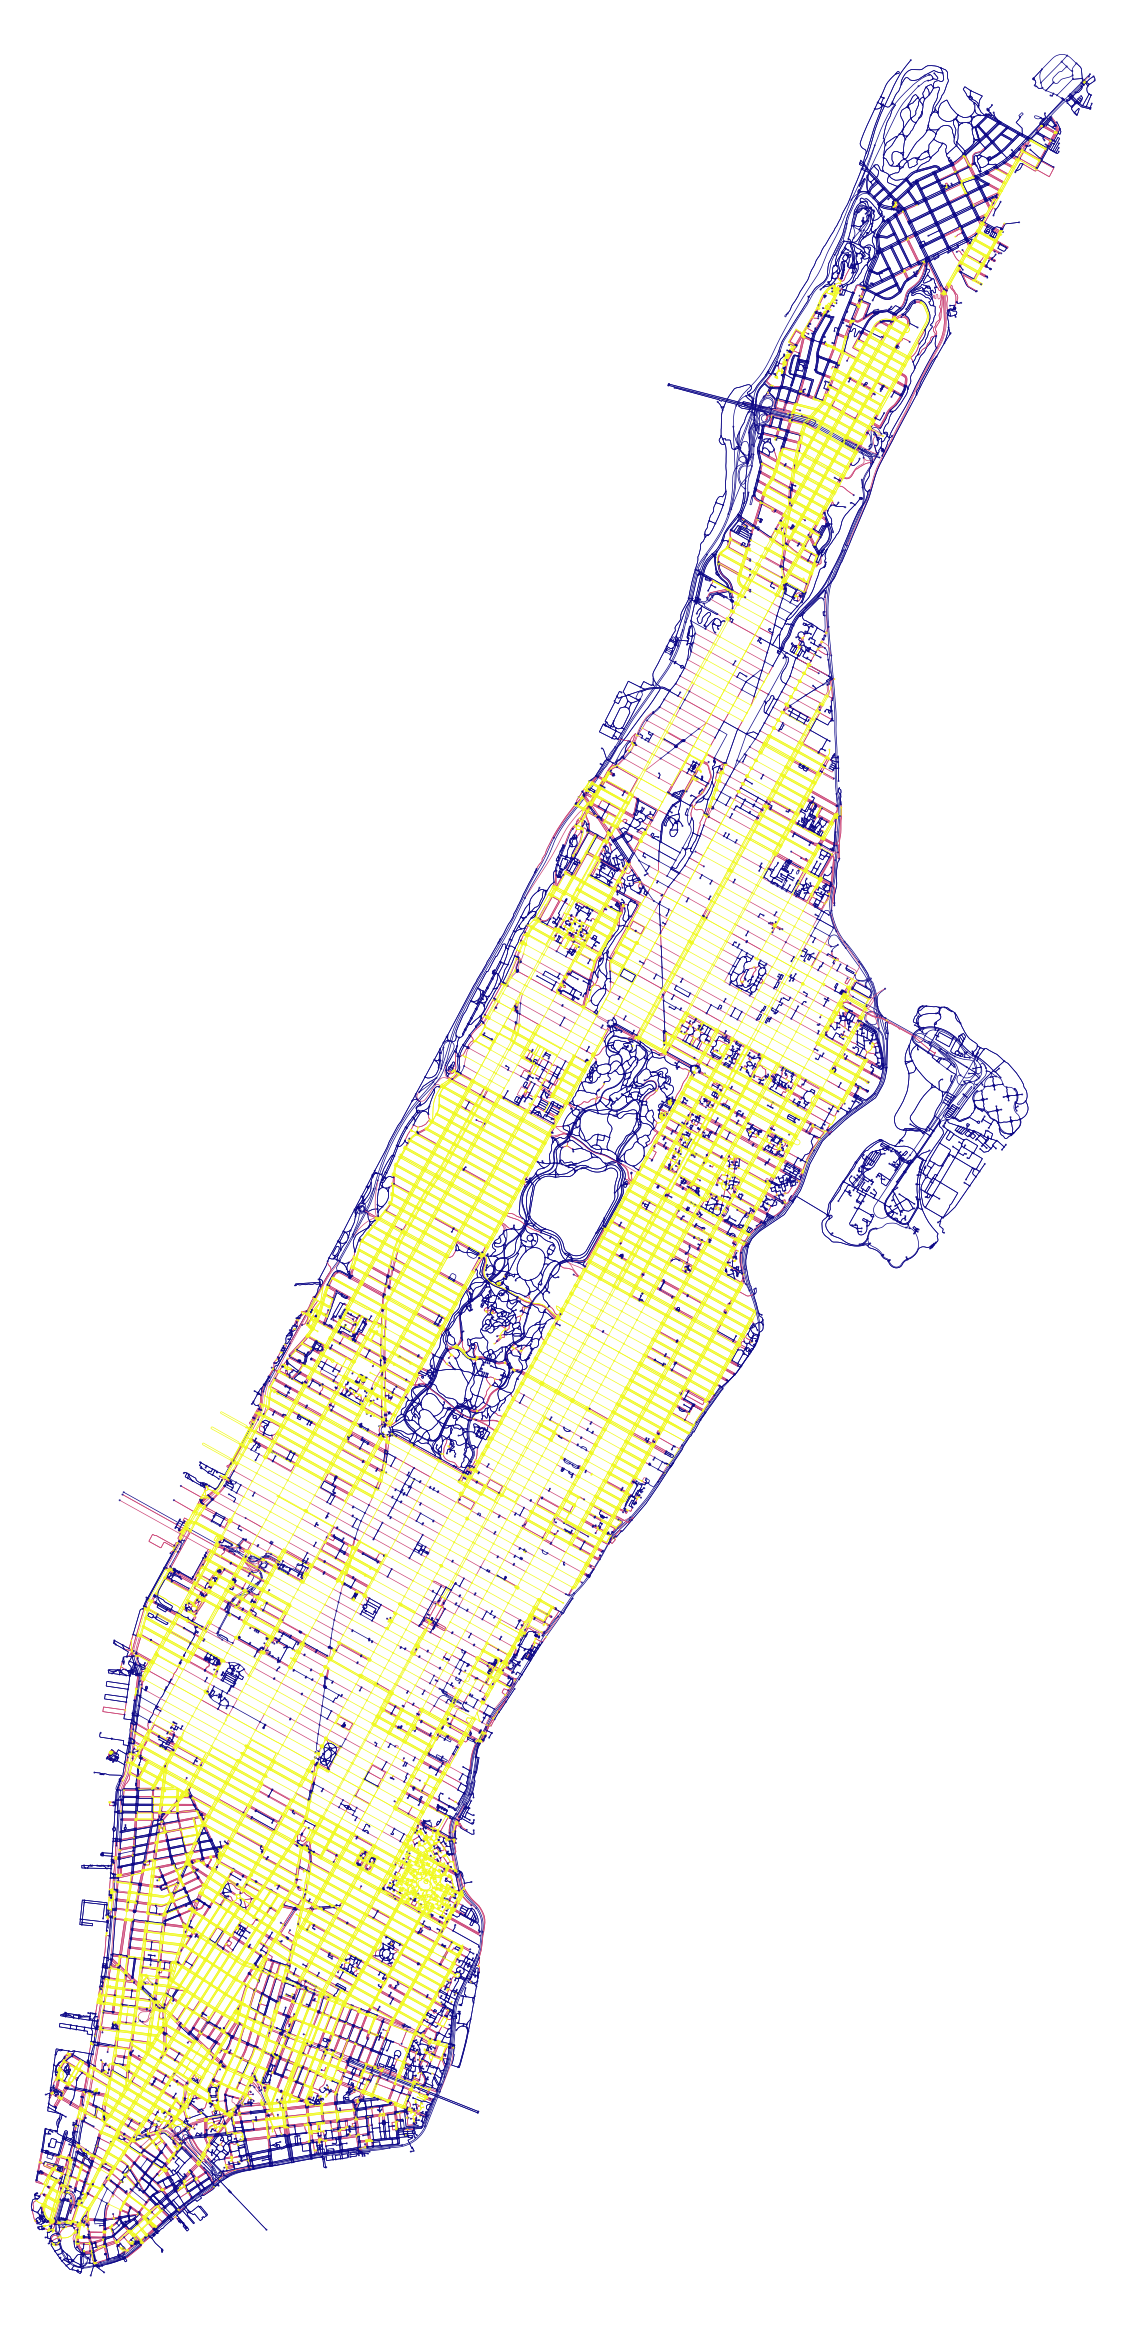

In [263]:
fig, ax = ox.plot_graph(G, bgcolor='white',
                        node_color=ox.plot.get_node_colors_by_attr(
                            G, 'node_color', start=-0.5, stop=1.5,
                            cmap='plasma'),
                        edge_color=ox.plot.get_edge_colors_by_attr(
                            G, 'edge_color', start=-0.5, stop=1.5,
                            cmap='plasma'),
                        node_size=2, node_alpha=0.8, edge_linewidth=0.5,
                        figsize=(15, 30),
                        save=True, filepath='bigPlotFourier.pdf'
                        )

In [ ]:
ox.plot_graph_folium(G_filtered, zoom=18)